# In this notebook we visualize effects of inserting a single CTCF in multiple backgrounds

In [1]:
import bioframe
import pandas as pd
import numpy as np
import tensorflow as tf
from basenji import dna_io
import akita_utils
from akita_utils.format_io import h5_to_df, multi_h5_to_df
from akita_utils.tsv_gen_utils import filter_boundary_ctcfs_from_h5, generate_ctcf_motifs_df, calculate_mean
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import h5py

# Importing scores from simulations

In [2]:
def remove_duplicate_columns(df):
    # Transpose the DataFrame
    transposed_df = df.T

    # Drop duplicates from the transposed DataFrame
    deduplicated_df = transposed_df.drop_duplicates()

    # Transpose the deduplicated DataFrame back to the original orientation
    result_df = deduplicated_df.T

    # Return the deduplicated DataFrame
    return result_df

# generate_locus_specification_list(dataframe=seq_coords_df, unique_identifier=unique_identifier)

In [3]:
h5_dirs = "/scratch1/kamulege/insert_experiments/11_uniformly_selcted_model6_motifs_v2/*/*/*.h5"

multi_model_df = multi_h5_to_df(h5_dirs)

def calculate_mean_stats_across_models(df, stats, models=None):
    new_df = pd.DataFrame()
    
    for stat in stats:
        new_df[stat] = calculate_mean(df, stat)
        
    if models:
        for model in models:
            model_df = df[[col for col in df.columns if f"m{model}" in col]]
            for stat in stats:
                new_df[f"{stat}_m{model}"] = calculate_mean(model_df, stat)
        
    return pd.concat([new_df, df], axis=1)



# multi_model_df_targets = calculate_mean_stats_across_targets(multi_model_df, models=[0,1,2,3,4,5,6,7], heads=[1], stats=["SCD", "SSD"])
multi_model_df_1 = calculate_mean_stats_across_models(multi_model_df, models=[0,1,2,3,4,5,6,7], stats=["SCD", "SSD"])

# multi_model_df_1

No columns matching 'SCD' found in the DataFrame.
No columns matching 'SSD' found in the DataFrame.


In [4]:
uniformly_selcted_model2_motifs_h5_dirs = "/scratch1/kamulege/insert_experiments/11_uniformly_selcted_model6_motifs_v2/*/*/*.h5"
uniformly_selcted_model2_motifs_df = multi_h5_to_df(uniformly_selcted_model2_motifs_h5_dirs)
uniformly_selcted_model2_motifs_df = calculate_mean_stats_across_models(uniformly_selcted_model2_motifs_df, models=[0,1,2,3,4,5,6,7], stats=["SCD", "SSD"])


model0_strong_30_h5_dirs = (
    "/scratch1/kamulege/insert_experiments/model0_strong_30/*/*/*.h5"
)
model0_strong_30_motifs_df = multi_h5_to_df(model0_strong_30_h5_dirs)
model0_strong_30_motifs_df = calculate_mean_stats_across_models(model0_strong_30_motifs_df, models=[0,1,2,3,4,5,6,7], stats=["SCD", "SSD"])


model0_uniform_100_h5_dirs = (
    "/scratch1/kamulege/insert_experiments/model0_uniform_100/*/*/*.h5"
)
model0_uniform_100_motifs_df = multi_h5_to_df(model0_uniform_100_h5_dirs)
model0_uniform_100_motifs_df = calculate_mean_stats_across_models(model0_uniform_100_motifs_df, models=[0,1,2,3,4,5,6,7], stats=["SCD", "SSD"])


No columns matching 'SCD' found in the DataFrame.
No columns matching 'SSD' found in the DataFrame.


In [5]:
# motifs_df = model0_strong_30_motifs_df
motifs_df = model0_uniform_100_motifs_df
# motifs_df = uniformly_selcted_model2_motifs_df

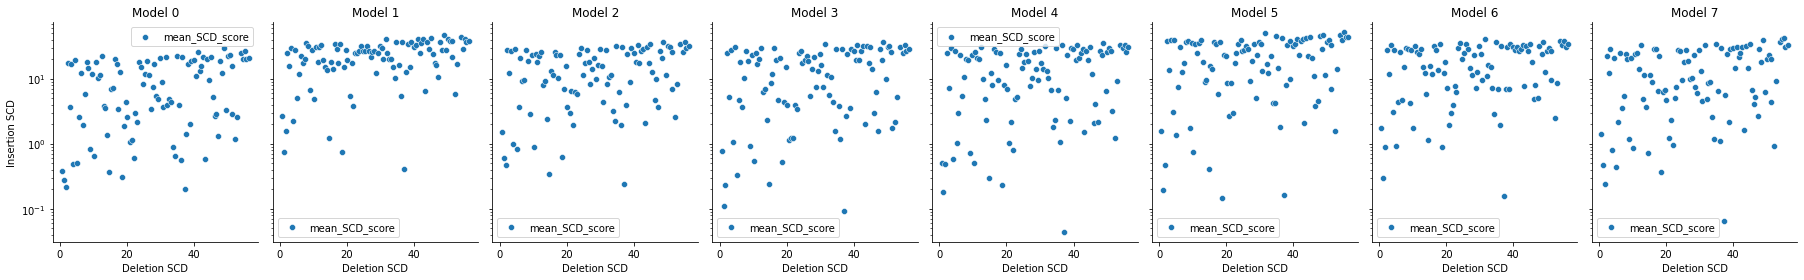

In [6]:
data = remove_duplicate_columns(motifs_df)

# Create the plot
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(25, 4), sharey=True)

for model, ax in enumerate(axes):
    sns.scatterplot(
        data=data,
        ax=ax,
        x="CTCF_1_genomic_SCD",
        y=f"SCD_m{model}", 
        label="mean_SCD_score",
    )
    sns.despine(top=True, right=True)
    ax.set_title(f"Model {model}")
    ax.set_xlabel("Deletion SCD")
    ax.set_ylabel("Insertion SCD")
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set axes to use log scale
for ax in axes:
    # ax.set_xscale("log")
    ax.set_yscale("log")

# Display the plot
plt.show()

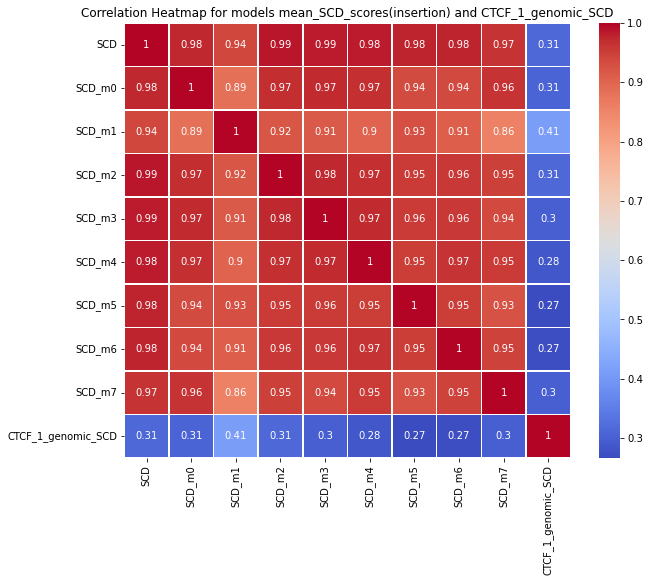

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# data = remove_duplicate_columns(motifs_df)

# Filter columns that contain "SCD", "SSD", f"SSD_m{model}" for model in [0,1,2,3,4,5,6,7], and "CTCF_1_genomic_SCD" in their names
columns_of_interest = [
    col
    for col in data.columns
    if col.endswith(("SCD", "SSD", "CTCF_1_genomic_SCD")) or any(col == f"SCD_m{model}" for model in [0, 1, 2, 3, 4, 5, 6, 7])
]

# Select the data for the filtered columns
data_selected = data[columns_of_interest]

# Calculate correlation matrix
correlation_matrix = data_selected.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap for models mean_SCD_scores(insertion) and CTCF_1_genomic_SCD")
plt.show()


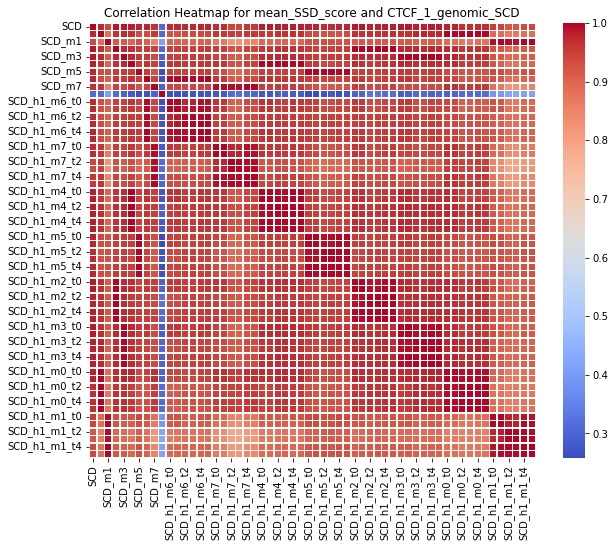

In [9]:

# Filter columns that contain "mean_SCD_score" and "CTCF_1_genomic_SCD" in their names
columns_of_interest = [
    col
    for col in data.columns
    if "SCD" in col
]
data_selected = data[columns_of_interest]

# Calculate correlation matrix
correlation_matrix = data_selected.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap for mean_SSD_score and CTCF_1_genomic_SCD")
plt.show()